In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
simple_transform=transforms.Compose([transforms.ToTensor()])
exp_dataset=datasets.CIFAR10('./data',train=True,download=True,transform=simple_transform)

Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(exp_dataset, batch_size=len(exp_dataset), shuffle=False)
data = next(iter(train_loader))

# Calculate mean and std per channel
mean = data[0].mean(dim=(0, 2, 3))  # Calculate mean across all images and height, width dimensions
std = data[0].std(dim=(0, 2, 3))    # Calculate std across all images and height, width dimensions

print("Mean per channel:", mean)
print("Std per channel:", std)

Mean per channel: tensor([0.4914, 0.4822, 0.4465])
Std per channel: tensor([0.2470, 0.2435, 0.2616])


In [4]:
train_transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
                                   ])
test_transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
                                   ])
train_data=datasets.CIFAR10('./data',train=True,download=True,transform=train_transform)
test_data=datasets.CIFAR10('./data',train=False,download=True,transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


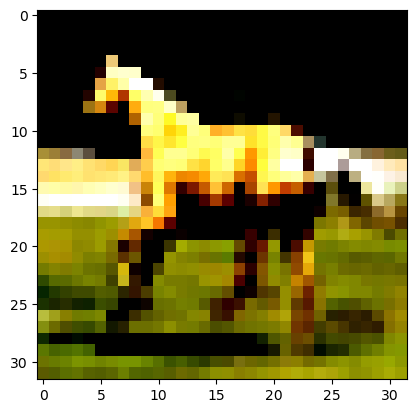

In [7]:
# train_data_n = train_data.train_data
# train_data_n = train_data.transform(train_data_n.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train_data.train_data.size())
# print(' - min:', torch.min(train_data_n))
# print(' - max:', torch.max(train_data_n))
# print(' - mean:', torch.mean(train_data_n))
# print(' - std:', torch.std(train_data_n))
# print(' - var:', torch.var(train_data_n))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)
%matplotlib inline
import matplotlib.pyplot as plt

# Let's visualize some of the images
try:
    plt.imshow(images[0])
except Exception as e:
    print(e)
print(images[0].shape, images[0].permute(1,2,0).shape)
plt.imshow(images[0].permute(1,2,0))
plt.show()

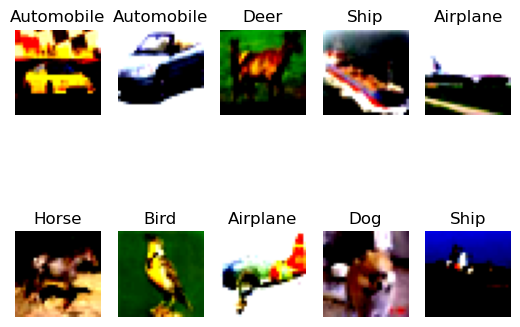

In [8]:
num_images=10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for index in range(1,num_images+1):
    plt.subplot(2, 5, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1,2,0).clamp(0, 1))
    plt.title(f"{class_names[labels[index]]}")
    #print(class_names[labels[index]])

In [9]:
from tqdm import tqdm
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        train_loss+=loss.item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accuracy=100*correct/processed
    train_loss=train_loss/len(train_loader)
    return train_loss,train_accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy=100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss,test_accuracy

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([5, 32, 32]),
            nn.Dropout(0.1)
        ) # output_size = 30,rf=3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([10, 32, 32]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        # output_size = 32,rf=5
        # TRANSITION BLOCK 1
        self.tn1=nn.Sequential(nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(1, 1), padding=0, bias=False),
                            nn.MaxPool2d(2, 2))
        # output_size = 16,rf=6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([8, 16, 16]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        #output_size=16,rf=10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([8, 16, 16]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        #output_size=16,rf=14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([10, 16, 16]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        #output_size=16,rf=16
        self.tn2=nn.Sequential(nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(1, 1), padding=0, bias=False),
                            nn.MaxPool2d(2, 2))
        #output_size=8,rf=18
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([8, 8, 8]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        #output_size=8,rf=26
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([8, 8, 8]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        #output_size=8,rf=32
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([12, 8, 8]),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        #output_size=8,rf=40


        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) 
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False))
        
    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.tn1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.tn2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x=self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



In [30]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 32, 32]             135
         LayerNorm-2            [-1, 5, 32, 32]          10,240
           Dropout-3            [-1, 5, 32, 32]               0
            Conv2d-4           [-1, 10, 32, 32]             450
         LayerNorm-5           [-1, 10, 32, 32]          20,480
              ReLU-6           [-1, 10, 32, 32]               0
           Dropout-7           [-1, 10, 32, 32]               0
            Conv2d-8            [-1, 5, 32, 32]              50
         MaxPool2d-9            [-1, 5, 16, 16]               0
           Conv2d-10            [-1, 8, 16, 16]             360
        LayerNorm-11            [-1, 8, 16, 16]           4,096
             ReLU-12            [-1, 8, 16, 16]               0
          Dropout-13            [-1, 8, 16, 16]               0
           Conv2d-14            [-1

In [31]:
device = torch.device("mps")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1, 21):
    print(epoch)
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    test_loss,test_accuracy=test(model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

1


loss=1.8936033248901367 batch_id=781 Accuracy=20.73: 100%|█| 782/782 [00:24<00:0



Test set: Average loss: 1.9428, Accuracy: 2413/10000 (24%)

2


loss=1.617479681968689 batch_id=781 Accuracy=25.41: 100%|█| 782/782 [00:20<00:00



Test set: Average loss: 1.8900, Accuracy: 2594/10000 (26%)

3


loss=2.3226871490478516 batch_id=781 Accuracy=29.28: 100%|█| 782/782 [00:21<00:0



Test set: Average loss: 1.8087, Accuracy: 2953/10000 (30%)

4


loss=1.5401787757873535 batch_id=781 Accuracy=32.79: 100%|█| 782/782 [00:21<00:0



Test set: Average loss: 1.6721, Accuracy: 3701/10000 (37%)

5


loss=1.803429365158081 batch_id=781 Accuracy=36.28: 100%|█| 782/782 [00:18<00:00



Test set: Average loss: 1.5745, Accuracy: 4013/10000 (40%)

6


loss=1.8708388805389404 batch_id=781 Accuracy=39.83: 100%|█| 782/782 [00:19<00:0



Test set: Average loss: 1.6801, Accuracy: 3609/10000 (36%)

7


loss=1.147789716720581 batch_id=781 Accuracy=42.27: 100%|█| 782/782 [00:18<00:00



Test set: Average loss: 1.5786, Accuracy: 3885/10000 (39%)

8


loss=1.7211216688156128 batch_id=781 Accuracy=45.32: 100%|█| 782/782 [00:19<00:0



Test set: Average loss: 1.4862, Accuracy: 4386/10000 (44%)

9


loss=1.5871262550354004 batch_id=781 Accuracy=47.22: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.4237, Accuracy: 4752/10000 (48%)

10


loss=1.5101267099380493 batch_id=781 Accuracy=49.08: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.3867, Accuracy: 4969/10000 (50%)

11


loss=1.0401071310043335 batch_id=781 Accuracy=50.61: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.4211, Accuracy: 4764/10000 (48%)

12


loss=0.999099612236023 batch_id=781 Accuracy=52.08: 100%|█| 782/782 [00:18<00:00



Test set: Average loss: 1.3841, Accuracy: 4921/10000 (49%)

13


loss=1.1896275281906128 batch_id=781 Accuracy=53.27: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.3098, Accuracy: 5225/10000 (52%)

14


loss=1.1919286251068115 batch_id=781 Accuracy=53.63: 100%|█| 782/782 [00:19<00:0



Test set: Average loss: 1.2653, Accuracy: 5356/10000 (54%)

15


loss=0.9315193891525269 batch_id=781 Accuracy=54.42: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.2930, Accuracy: 5257/10000 (53%)

16


loss=1.2824217081069946 batch_id=781 Accuracy=55.16: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.2105, Accuracy: 5584/10000 (56%)

17


loss=1.0247774124145508 batch_id=781 Accuracy=56.16: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.2289, Accuracy: 5470/10000 (55%)

18


loss=0.9738767743110657 batch_id=781 Accuracy=56.55: 100%|█| 782/782 [00:18<00:0



Test set: Average loss: 1.1856, Accuracy: 5697/10000 (57%)

19


loss=1.2277748584747314 batch_id=781 Accuracy=56.73: 100%|█| 782/782 [00:17<00:0



Test set: Average loss: 1.2127, Accuracy: 5546/10000 (55%)

20


loss=0.7198402881622314 batch_id=781 Accuracy=57.04: 100%|█| 782/782 [00:17<00:0



Test set: Average loss: 1.2186, Accuracy: 5596/10000 (56%)



In [38]:
model_eval=model.eval()
device = torch.device("mps")
wrong_predictions = []
with torch.no_grad():
    for data, target in test_data:
        data, target = data.to(device), target
        output = model(data.unsqueeze(0))
        pred = torch.argmax(output, 1)
        if(pred!=target):
            wrong_predictions.append((data, pred, target))

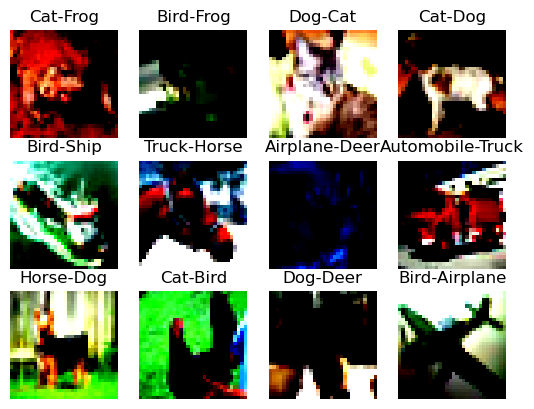

In [41]:
for i in range(1,min(13, len(wrong_predictions))):
    plt.subplot(3,4,i)
    plt.axis('off')
    image, predicted, label = wrong_predictions[i]
    image = image.permute(1, 2, 0)  # Rearrange dimensions for plotting (assuming channels are last)    
    # Plot the image
    plt.imshow(image.to("cpu").clamp(0,1))
    plt.title(f"{class_names[predicted]}-{class_names[label]}")